## Benchmark Model

- Training data made with some overlap
- feature set 4; ie with additional stats components, and derivative/integral components

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from functools import reduce
from tqdm import tqdm_notebook
from sklearn.metrics import mean_absolute_error
from IPython.display import display
import gen_features
from multiprocessing import Process, Value
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('whitegrid')

fset = 4

#### 1) Extract dataset with features and target from csv files

In [2]:
# Read specified chunks of training data
if "feature_set{}.csv".format(fset) not in os.listdir("Features"):
    read_chunks = list(range(1,141))
    data_list = []
    folder = "temp"
    filename = 'text.txt'
    kwargs = {'gen_features' : gen_features.gen_features4,
              'overlap_ratio' : 0.25,
             }
    for k in tqdm_notebook(read_chunks):
        p = Process(target=gen_features.gen_dim_reduced_dataset,args=(k,),kwargs=kwargs)
        p.start()
        p.join()
        if k%20 == 0:
            with open(os.path.join(folder,filename),'r') as file:
                print(file.read())
    
    data_list = [pd.read_csv(os.path.join("temp","dim_reduced_train{}.csv".format(k))).iloc[:,1:] for k in read_chunks]
    data = pd.concat(data_list,axis=0,ignore_index=True)
    data.to_csv(os.path.join("Features","feature_set{}.csv".format(fset)))
else:
    print("Feature set {} already extracted.".format(fset))
    data = pd.read_csv(os.path.join("Features","feature_set{}.csv".format(fset))).iloc[:,1:]

Feature set 4 already extracted.


In [3]:
x_df = data.drop(['time_to_failure'],axis=1)
y_df = data['time_to_failure']

In [4]:
data.tail()

,mean,std,max,min,skew,kurtosis,r10_std,r100_std,r1000_std,1diff_mean,1diff_std,2diff_std,cumsum_max,num > q0.995,time_to_failure
16709,4.489550,3.454761,64,-66,-0.108652,15.753992,1.575053,0.355076,0.213360,0.000047,3.157097,4.821477,3866.306831,732,9.760800
16710,4.479615,3.448699,64,-66,-0.139434,17.734203,1.586974,0.356590,0.214267,-0.000017,3.151585,4.813932,5418.292098,599,9.759796
16711,4.493480,3.670229,64,-66,-0.171886,19.836235,1.712873,0.359228,0.214935,0.000000,3.189568,4.817990,4912.382225,379,9.759796
16712,4.565128,3.282740,46,-33,0.013554,6.720458,1.451719,0.354214,0.217487,0.000022,3.133986,4.815550,2919.347230,223,9.759796
16713,4.648496,3.151858,26,-13,0.084372,1.003229,1.363908,0.311552,0.160577,-0.000627,3.107681,4.784565,375.255639,39,9.759796


#### 3) Explore the data (only basic comparisons, since this is only for the benchmark model)

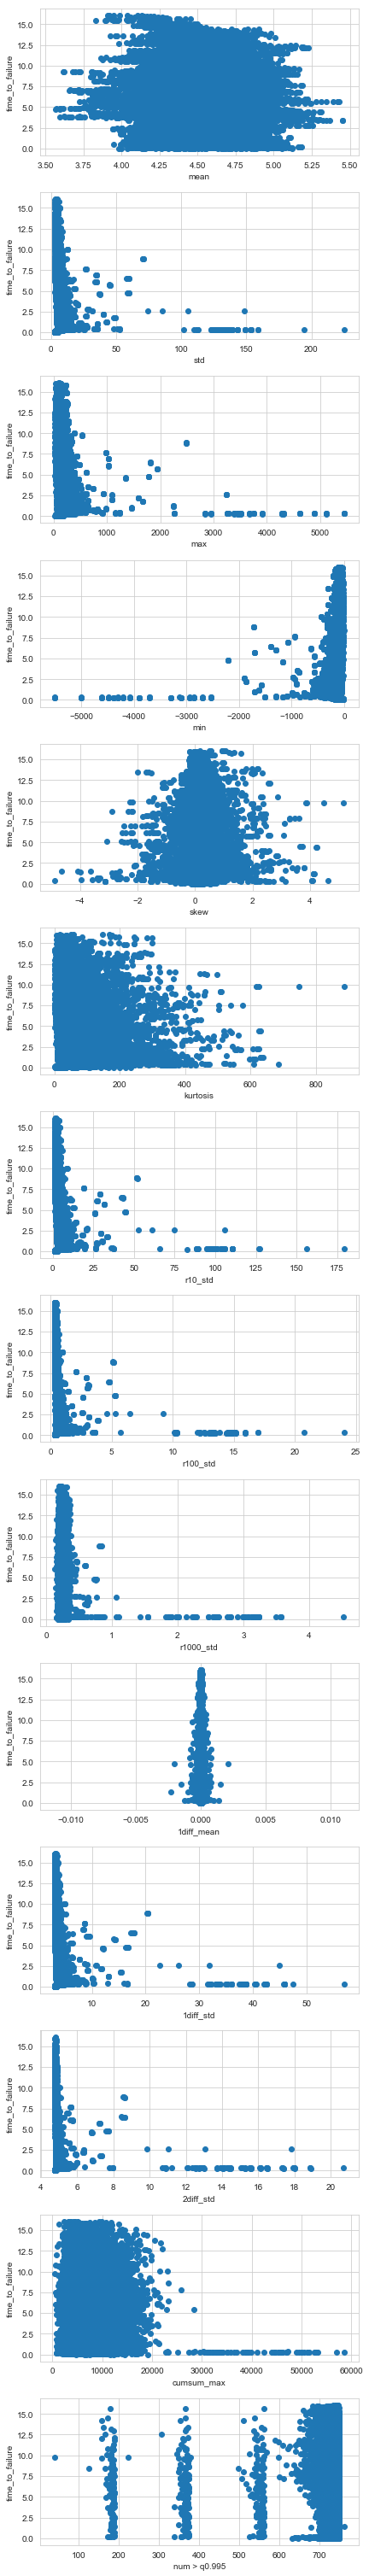

In [5]:
nrows = x_df.shape[1]
fig, axes = plt.subplots(nrows,figsize = (6,nrows*3))

for i,axis in enumerate(axes):
    axis.scatter(x_df.iloc[:,i],y_df)
    axis.set_xlabel(x_df.columns[i])
    axis.set_ylabel('time_to_failure')
plt.tight_layout()

#### 4) Split data into training and testing data

- Use 35% of data for testing

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_df,y_df,test_size=0.35,random_state = 0)

#### 5) Set up an Initial model for Random Forest Regressor

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [26]:
regressor = RandomForestRegressor(criterion='mae')
res = cross_val_score(regressor,X_train,y_train.values.ravel(),
                      scoring='neg_mean_absolute_error',cv=4,n_jobs=-1,verbose=5)
print('Mean CV score: {:.3f}, Std. Dev. of CV scores {:.3f}'.format(
    np.mean(res),np.std(res)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   24.9s remaining:   24.9s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   25.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   25.6s finished


Mean CV score: -2.172, Std. Dev. of CV scores 0.003


#### 6) Investigate quality of initial model

In [9]:
# Make a final benchmark model by training on the entire training data
from sklearn.base import clone
regressor_final = clone(regressor)
regressor_final = regressor_final.fit(X_train,y_train.values.ravel())

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [10]:
# Plot Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    regressor_final,X_train,y_train.values.ravel(), cv=4,scoring='neg_mean_absolute_error')

Text(0.5, 1.0, 'Learning Curve for Benchmark Random Forest Regressor Model')

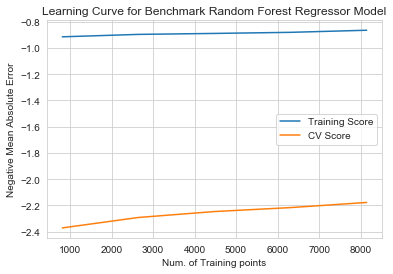

In [11]:
plt.plot(train_sizes,np.mean(train_scores,axis=1),label='Training Score')
plt.plot(train_sizes,np.mean(valid_scores,axis=1),label='CV Score')
plt.legend()
plt.xlabel('Num. of Training points')
plt.ylabel('Negative Mean Absolute Error')
plt.title('Learning Curve for Benchmark Random Forest Regressor Model')

The learning curve shows large divergence between the training and CV scores. This is a clear case of overfitting.

#### 7) Set up GridSearchCV to improve model by tuning hyperparameters

In [40]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth' : [4,6],
          #'min_samples_leaf' : [0.05],
          'n_estimators' : [40,80],
          }

grid = GridSearchCV(regressor,param_grid=params,scoring='neg_mean_absolute_error',
                   cv = 4,n_jobs=-1,verbose=10)
grid.fit(X_train,y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:  6.4min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed: 10.0min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 10.0min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [4, 6], 'n_estimators': [40, 80]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=10)

In [41]:
best_regr = grid.best_estimator_
best_regr

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

[learning_curve] Training set sizes: [ 814 2648 4481 6314 8148]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    9.4s remaining:   53.8s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:  1.1min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:  2.3min remaining:   45.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.7min finished


Text(0.5, 1.0, 'Learning Curve for Benchmark Random Forest Regressor Model')

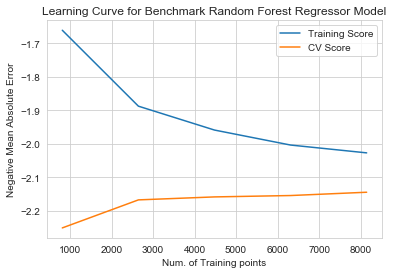

In [44]:
# Plot Learning Curve
train_sizes, train_scores, valid_scores = learning_curve(
    best_regr,X_train,y_train.values.ravel(), cv=4,scoring='neg_mean_absolute_error',n_jobs=-1,verbose=4)

plt.plot(train_sizes,np.mean(train_scores,axis=1),label='Training Score')
plt.plot(train_sizes,np.mean(valid_scores,axis=1),label='CV Score')
plt.legend()
plt.xlabel('Num. of Training points')
plt.ylabel('Negative Mean Absolute Error')
plt.title('Learning Curve for Benchmark Random Forest Regressor Model')

In [45]:
for i,j in zip(x_df.columns,best_regr.feature_importances_):
    print("{} : {:.3f}".format(i,j))

mean : 0.051
std : 0.013
max : 0.011
min : 0.008
skew : 0.011
kurtosis : 0.109
r10_std : 0.022
r100_std : 0.011
r1000_std : 0.012
1diff_mean : 0.002
1diff_std : 0.657
2diff_std : 0.083
cumsum_max : 0.004
num > q0.995 : 0.006


In [46]:
res2 = cross_val_score(best_regr,X_train,y_train.values.ravel(),
                      scoring='neg_mean_absolute_error',cv=4,n_jobs=-1, verbose = 5)
print('Mean CV score: {:.3f}, Std. Dev. of CV scores {:.3f}'.format(
    np.mean(res2),np.std(res2)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.6min finished


Mean CV score: -2.142, Std. Dev. of CV scores 0.022


In [47]:
y_train_pred = best_regr.predict(X_train)
y_test_pred = best_regr.predict(X_test)

train_score = mean_absolute_error(y_train,y_train_pred)
test_score = mean_absolute_error(y_test,y_test_pred)

print(train_score)
print(test_score)

2.0464902136786445
2.1390086164444027


In [87]:
benchmark_pred = pd.DataFrame(best_regr.predict(data.iloc[:,:-1]),index=data.index,columns = ['Benchmark Prediction'])

Text(0.5, 0, 'Sample #')

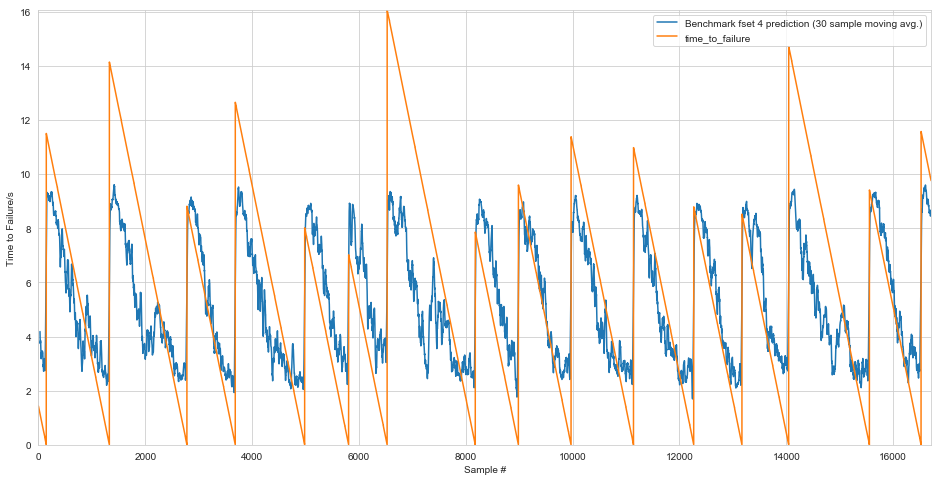

In [89]:
xdata = data.iloc[:,:-1]
normalized_xdata = (xdata-xdata.min())/(xdata.max()-xdata.min())
fig,axis = plt.subplots(figsize=(16,8))
window = 30
axis.plot(benchmark_pred.rolling(window).mean(),
          label="Benchmark fset {} prediction ({} sample moving avg.)".format(fset,window))
axis.plot(data['time_to_failure'])
plt.legend()
plt.xlim((data.index[0],data.index[-1]))
plt.ylim((0,data['time_to_failure'].max()))
plt.ylabel('Time to Failure/s')
plt.xlabel('Sample #')

Similar to the paper, the stndard deviation is found to be the most useful parameter in predicting the time remaining until the next earthquake.

In [ ]:
best_regr.class_weight

### Make Kaggle Competition Submission csv

In [90]:
if "submission_features{}.csv".format(fset) not in os.listdir("Features"):
    gen_features.gen_submission_features(gen_features=gen_features.gen_features4,fset=fset)

In [91]:
submission_raw = pd.read_csv(os.path.join("Features","submission_features4.csv")).iloc[:,1:]
submission = pd.concat([submission_raw['seg_id'],
                        pd.Series(best_regr.predict(submission_raw.iloc[:,1:].values),name='time_to_failure')],
                      axis=1)
submission.to_csv(os.path.join("Submissions","Benchmark_fset4.csv"),index=False)